# Section 3: Gradient Descent

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch
from torch import nn
from datetime import datetime

device = (torch.device('cpu'))
seed = 123
#TODO: details: seed in example is 
#seed = 265 
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

## Define function for loading and preprocessing CIFAR data

In [2]:
def load_cifar(train_val_split=0.9, 
               data_path='./data/', 
               preprocessor=None, 
               seed=123, 
               keep_labels=['plane', 'bird']):
    '''
    Parameters
    ----------
    train_val_split : double
        Split ratio between train data and validation data.
    data_path : str
        Path where data is stored. Data is downloaded if is does not already excist
    preprocessor : torchvision.transforms.transforms.Compose
        Preprocessor for preprocessing data. Default used if none is provided
    seed : int
        Random seed used in random operations
    keep_labels : list
        List of image labels we want from cifar10 dataset

    Returns
    -------
    data_train : torch.utils.data.dataset.Subset
        Training data
    data_val : torch.utils.data.dataset.Subset
        Validation data
    data_test : torch.utils.data.dataset.Subset
        Testing data

    '''
    
    # Define preprocessor if not already given
    if preprocessor is None:
        preprocessor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468),
                                (0.2470, 0.2435, 0.2616))])
    
    # Load training and validation data
    data_train_val = datasets.CIFAR10(
        data_path,       
        train=True,      
        download=True,
        transform=preprocessor)
    
    # Split training and testing data
    n_train = int(len(data_train_val)*train_val_split)
    n_val =  len(data_train_val) - n_train

    data_train, data_val = random_split(
        data_train_val, 
        [n_train, n_val], 
        generator=torch.Generator().manual_seed(seed))
    
    # Load testing data
    data_test = datasets.CIFAR10(
        data_path,       
        train=False,      
        download=True,
        transform=preprocessor)

    # Identify which labels too keep
    labels = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 
               'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}
    final_labels = list(map(labels.get, keep_labels))
    
    label_map = {}
    for i, label in enumerate(final_labels):
        label_map[label] = i
    
    # Shave off datasets, only keeping the wanted labels
    data_train = [(img, label_map[label]) for img, label in data_train if label in final_labels]
    data_val = [(img, label_map[label]) for img, label in data_val if label in final_labels]
    data_test = [(img, label_map[label]) for img, label in data_test if label in final_labels]
    
    # Print data set sizes for sanity check
    print("Size of the train dataset:        ", len(data_train))
    print("Size of the validation dataset:   ", len(data_val))
    print("Size of the test dataset:         ", len(data_test))
    
    return data_train, data_val, data_test

## Build Neural Network

In [3]:
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Number of layers in network
        self.L = 4
        
        # Initialize Zs and As to dictionary
        # Z[l] = W[l]A[l-1] + b[l]
        # A[l] = g[Z[l]]
        self.z = {i:None for i in range(1, self.L+1)}
        self.a = {i:None for i in range(self.L+1)}
        
        '''
        Create fully connected (fc) layers
        Layers:
            n[l0] = 3072
            n[l1] = 512
            n[l2] = 128
            n[l3] = 32
            n[l4] = 2
        '''
        self.fc = nn.ModuleDict({str(i):None for i in range(1, self.L+1)})
        self.fc['1'] = nn.Linear(in_features=3072, out_features=512)
        self.fc['2'] = nn.Linear(in_features=512, out_features=128)
        self.fc['3'] = nn.Linear(in_features=128, out_features=32)
        self.fc['4'] = nn.Linear(in_features=32, out_features=2)
        
        
    def forward(self, x):
        
        # Input layer
        self.a[0] = torch.flatten(x, 1)
        
        # First layer
        self.z[1] = self.fc['1'](self.a[0])
        self.a[1] = torch.relu(self.z[1])
        
        # Second layer
        self.z[2] = self.fc['2'](self.a[1])
        self.a[2] = torch.relu(self.z[2])
        
        # Third layer 
        self.z[3] = self.fc['3'](self.a[2])
        self.a[3] = torch.relu(self.z[3])
        
        # Fourth layer (output layer)
        self.z[4] = self.fc['4'](self.a[3])
        self.a[4] = self.z[4]
        
        return self.a[4]

## Define training pipelines

In [11]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, verbose = True):
    # Neural network training pipeline using pytorch's SGD
    
    if verbose:
        print(" --------- Using Pytorch's SGD ---------")
    
    n_batches = len(train_loader)
    
    losses_train = []

    for epoch in range(1, n_epochs+1):
        
        epoch_loss = 0
        
        # For each batch in train_loader
        for batch in train_loader:
            # Split batch into  
            inputs, labels = batch
            
            # Zero gradient for every batch
            model.zero_grad()
            
            # Make predictions for this batch
            outputs = model(inputs.double())
            
            # Compute loss
            loss = loss_fn(outputs, labels)
            
            # Compute gradient
            loss.backward()  
            
            # Adjust parameters
            optimizer.step()
            
            # Add loss from current batch
            epoch_loss += loss.item()
            
        losses_train.append(epoch_loss / n_batches)
        
        if verbose and (epoch == 1 or epoch % 5 == 0):
            print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
                datetime.now().time(), epoch, epoch_loss/n_batches))
            
    return losses_train, model

In [12]:
def train_manual_update(n_epochs, lr, weight_decay, momentum, model, loss_fn, train_loader, verbose=True):
    # Neural network training pipeline using manual gradient descent
    if verbose:
        print(" --------- Using Manual Update ---------")
    
    n_batches = len(train_loader)
    b = [None, None, None, None, None, None, None, None]
    
    losses_train = []

    for epoch in range(1, n_epochs+1):
        
        epoch_loss = 0
        
        # For each batch in train_loader
        for batch in train_loader:
            # Split batch into  
            inputs, labels = batch
            
            # Zero gradient for every batch
            model.zero_grad()
            
            # Make predictions for this batch
            outputs = model(inputs.double())
            
            # Compute loss
            loss = loss_fn(outputs, labels)
            
            # Compute gradient
            loss.backward()  
            
            # Adjust parameters
            for i, p in enumerate(model.parameters()):
                # Add L2 regularization
                grad = p.grad + weight_decay*p.data
                # Add momentum
                if momentum != 0:
                    if b[i] == None:
                        b[i] = grad
                    else:
                        b[i] = momentum*b[i] + grad
                    grad = b[i]
                
                p.data = p.data - lr*grad
            
            # Add loss from current batch
            epoch_loss += loss.item()
            
        losses_train.append(epoch_loss / n_batches)
        
        if verbose and (epoch == 1 or epoch % 5 == 0):
            print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
                datetime.now().time(), epoch, epoch_loss/n_batches))
            
    return losses_train, model

Loop for hyperparameter testing and output print statements (made to match ``gradient_descent_output.txt``):

In [6]:
def calculate_accuracy(y_pred, y_true):
    #TODO: vary good (too good?) validation accuracies seem unlikely? Is there a mistake here or somewhere else?
    """ calculates fraction of predictions that are correct """
    good_predictions = (y_pred == y_true)
    # counting number of true entries in boolean tensor
    correct = len(good_predictions.masked_select(good_predictions == True))
    acc = correct / len(y_true) # fraction of correct predictions
    
    return acc

# set global hyperparameters
n_epochs = 30
batch_size = 256
loss_fn = nn.CrossEntropyLoss()
lr = 0.01

# load data
data_train, data_val, data_test = load_cifar()
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=False)

# Split X and y
train_set = torch.utils.data.DataLoader(data_train, batch_size=len(data_train), shuffle=False)
for data in train_set:
    x_train, y_train = data
val_set = torch.utils.data.DataLoader(data_train, batch_size=len(data_val), shuffle=False)
for data in val_set:
    x_validation, y_validation = data

print('\nTraining on device cpu.')

print('   Global parameters:')
print('batch_size = %d'%batch_size)
print('n_epoch =  %d'%n_epoch)
print('loss_fn =  CrossEntropyLoss()')
print('seed =  %d'%seed)
# for storing which MLP does the best
current_acc = 0
val_accs = []

# parameters to test (same as from output text)
moms = [0, 0, 0.9, 0.9, 0.8]
decays = [0, 0.01, 0, 0.01, 0.001, 0.01]


# use list of models to avoid having to train them so much? 
# not sure how this will work with all the pytorch subclass stuff

for i in range(len(moms)):
    mom = moms[i]
    decay = decays[i]
    
    print('\n =========================================================\n  Current parameters:')
    print('lr: %.2f'%lr)
    print('mom: %.2f'%mom)
    print('decay: %.2f\n'%decay)
    
    # Train your Pytorch's SGD MLP (model1) here and return y_pred_train from last loop of training
    model1 = MyMLP()
    optimizer = torch.optim.SGD(model1.parameters(), lr=lr, weight_decay=decay, momentum=mom)
    losses_train1, model1 = train(n_epochs, optimizer, model1, loss_fn, train_loader)
    y_pred_train = model1(x_train.double())
    y_pred_train = y_pred_train.max(axis=1)[1]
    
    # calculating accuracies from training
    acc_t = calculate_accuracy(y_pred_train, y_train)
    
    # calculate accuracies from validation set
    y_pred_val = model1(x_validation.double())
    y_pred_val = y_pred_val.max(axis=1)[1]
    acc_v = calculate_accuracy(y_pred_val, y_validation)
    if acc_v >= current_acc:
        best_mom = mom
        best_decay = decay
        best_SDG = 'PyTorch SDG'
        current_acc = acc_v
    
    print('\n --- Accuracies ---')
    print('Training\nAccuracy: %.2f'%acc_t)
    print('Validation\nAccuracy: %.2f\n'%acc_v)
    
    # Train your manual update MLP (model2) here and return y_pred_train from last loop of training
    model2 = MyMLP()
    losses_train2, model2 = train_manual_update(n_epochs, lr, decay, mom, model2, loss_fn, train_loader)
    y_pred_train = model2(x_train.double())
    y_pred_train = y_pred_train.max(axis=1)[1]
    
    # calculating accuracies from training
    acc_t = calculate_accuracy(y_pred_train, y_train)
    
    # calculate accuracies from validation set
    y_pred_val = model2(x_validation.double())
    y_pred_val = y_pred_val.max(axis=1)[1]
    acc_v = calculate_accuracy(y_pred_val, y_validation)
    val_accs.append(acc_v)
    if acc_v >= current_acc:
        best_mom = mom
        best_decay = decay
        best_SDG = 'Manual update'
        current_acc = acc_v
    
    print('\n --- Accuracies ---')
    print('Training\nAccuracy: %.2f'%acc_t)
    print('Validation\nAccuracy: %.2f\n'%acc_v)

# if we make function this could be used?    
# best_hyperparams = {'momentum' : best_mom, 'decay' : best_decay, 'SGD version' : best_SDG}

Files already downloaded and verified
Files already downloaded and verified
Size of the train dataset:         9017
Size of the validation dataset:    983
Size of the test dataset:          2000
  Current parameters:
lr: 0.01
mom: 0.00
decay: 0.00
 --------- Using Pytorch's SGD ---------
22:04:08.534610  |  Epoch 1  |  Training loss 0.69640
22:04:20.039313  |  Epoch 5  |  Training loss 0.55943
22:04:34.364872  |  Epoch 10  |  Training loss 0.46984
22:04:48.680984  |  Epoch 15  |  Training loss 0.42884
22:05:03.009240  |  Epoch 20  |  Training loss 0.39155
22:05:17.368357  |  Epoch 25  |  Training loss 0.35858
22:05:31.716179  |  Epoch 30  |  Training loss 0.32692

 --- Accuracies ---
Training
Accuracy: 0.87
Validation
Accuracy: 0.89

 --------- Using Manual Update ---------
22:05:36.100846  |  Epoch 1  |  Training loss 0.68580
22:05:47.996075  |  Epoch 5  |  Training loss 0.56936
22:06:02.859236  |  Epoch 10  |  Training loss 0.47856
22:06:17.713277  |  Epoch 15  |  Training loss 0.434

Questions 9 and 10:
Select the best model among those trained in the previous question based on their accuracy. Evaluate the best model.

In [13]:
print('\n --- Best model ---')
print('Learning rate: %.2f'%lr)
print('Momentum: %.2f'%best_mom)
print('Decay: %.2f'%best_decay)
print('SDG method: ' + best_SDG)
print('Validation accuracy: %.2f\n'%current_acc)

test_set = torch.utils.data.DataLoader(data_test, batch_size=len(data_test), shuffle=False)
for data in test_set:
    x_test, y_test = data

model = MyMLP()
if best_SDG == 'PyTorch SDG':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=best_decay, momentum=best_mom)
    losses_train, model = train(n_epochs, optimizer, model, loss_fn, train_loader, verbose=False)
else:
    losses_train, model = train_manual_update(n_epochs, lr, best_decay, best_mom, model, loss_fn, train_loader, verbose=False)
y_pred_test = model(x_test.double())
y_pred_test = y_pred_test.max(axis=1)[1]
acc_test = calculate_accuracy(y_pred_test, y_test)

print('Test accuracy: %.2f'%acc_test)


 --- Best model ---
Learning rate: 0.01
Momentum: 0.90
Decay: 0.00
SDG method: manual update
Validation accuracy: 1.00

Test accuracy: 0.85


Text(0, 0.5, 'Loss')

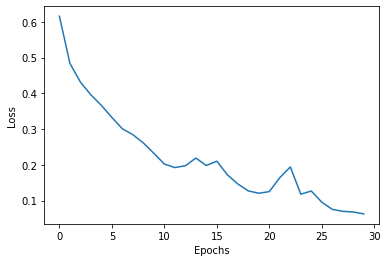

In [16]:
import matplotlib.pyplot as plt
epochs = [i for i in range(n_epochs)]
plt.plot(epochs, losses_train)
plt.xlabel('Epochs')
plt.ylabel('Loss')